# Metadata

```yaml
Course:   DS 5001
Module:   11 Lab
Topc:     TextBlob
Author:   R.C. Alvarado
Date:     10 April 2024
```

**Purpose:** Demonstrate use of TextBlob for SA and other tasks.

# Textblob

> TextBlob is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, and more.

> TextBlob aims to provide access to common text-processing operations through a familiar interface. You can treat TextBlob objects as if they were Python strings that learned how to do Natural Language Processing. 

[Source](https://textblob.readthedocs.io/en/dev/).

TextBlob uses the [Pattern](https://github.com/clips/pattern) library and [SentiWordNet](https://github.com/aesuli/sentiwordnet) lexicon to compute sentiment. 

It computes average polarity and subjectivity over each word in a given text using a dictionary of adjectives and their hand-tagged scores. 

The lexicon is [here](https://raw.githubusercontent.com/aesuli/SentiWordNet/master/data/SentiWordNet_3.0.0.txt).

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
text_file =  f"{data_home}/syuzhet/R/persuasion.txt"

In [3]:
import pandas as pd
from textblob import Blobber

# Create Object

In [4]:
blobber = Blobber()

In [5]:
TB = blobber(open(text_file, 'r').read())

# Extract Tables

## DOC

In [6]:
DOC = pd.DataFrame(dict(sent_str=[s.raw for s in TB.sentences]))
DOC.index.name = 'sent_num'

In [7]:
DOC['polarity'] = [s.polarity for s in TB.sentences]
DOC['subjectivity'] = [s.subjectivity for s in TB.sentences]

In [8]:
DOC

,sent_str,polarity,subjectivity
sent_num,,,
0,"Chapter 1\n\n\nSir Walter Elliot, of Kellynch ...",0.057143,0.475866
1,This\nwas the page at which the favourite volu...,0.000000,0.000000
2,"""Walter Elliot, born March 1, 1760, married, J...",0.250000,0.250000
3,"of South Park, in the county of\nGloucester, b...",0.000000,0.000000
4,Precisely such had the paragraph originally st...,0.208333,0.500000
...,...,...,...
3647,She\nmight have been absolutely rich and perfe...,0.558333,0.750000
3648,Her spring of felicity was in the glow of her ...,0.000000,0.000000
3649,"Anne was tenderness\nitself, and she had the f...",0.325000,0.325000


In [9]:
# TB.sentences[100].ngrams(5) #__dir__()

## TOKEN

In [10]:
TOKEN = pd.DataFrame(
    [(sent_num, token_num, pair[0], pair[1]) 
     for sent_num, sentence in enumerate(TB.sentences) 
     for token_num, pair in enumerate(sentence.tags)],
    columns=['sent_num', 'token_num', 'token_str', 'pos'])\
    .set_index(['sent_num', 'token_num'])

In [11]:
TOKEN

token_str   pos
sent_num token_num                  
0        0             Chapter    NN
         1                   1    CD
         2                 Sir   NNP
         3              Walter   NNP
         4              Elliot   NNP
...                        ...   ...
3651     32               than    IN
         33                 in    IN
         34                its  PRP$
         35           national    JJ
         36         importance    NN

[83830 rows x 2 columns]

In [12]:
TOKEN2 = pd.DataFrame(
    [(sent_num, token_num, *parse[0]) 
     for sent_num, sentence in enumerate(TB.sentences) 
     for token_num, parse in enumerate(sentence.parse().split())],
    columns=['sent_num', 'token_num', 'token_str', 'pos', 'parse_tree', 'parse_tree2'])\
    .set_index(['sent_num', 'token_num'])

In [13]:
TOKEN2

token_str   pos parse_tree parse_tree2
sent_num token_num                                       
0        0           Chapter    NN       B-NP           O
         1               Sir   NNP       B-NP           O
1        0              This    DT          O           O
         1                 "     "          O           O
2        0                 "     "          O           O
...                      ...   ...        ...         ...
3647     0               She   PRP       B-NP           O
3648     0               Her  PRP$       B-NP           O
3649     0              Anne   NNP       B-NP           O
3650     0               His  PRP$       B-NP           O
3651     0               She   PRP       B-NP           O

[4274 rows x 4 columns]

In [14]:
TOKEN2.parse_tree.value_counts()

parse_tree
B-NP      2196
O         1459
B-PP       253
B-VP       180
B-ADVP     152
B-ADJP      34
Name: count, dtype: int64

In [15]:
TOKEN2.value_counts(['parse_tree', 'parse_tree2']).unstack(fill_value=0)

parse_tree2,B-PNP,O
parse_tree,,
B-ADJP,0,34
B-ADVP,0,152
B-NP,0,2196
B-PP,208,45
B-VP,0,180
O,0,1459


In [16]:
TOKEN['term_str'] = TOKEN.token_str.str.replace(r"\W", "").str.lower().str.strip()

In [17]:
TOKEN

token_str   pos    term_str
sent_num token_num                              
0        0             Chapter    NN     chapter
         1                   1    CD           1
         2                 Sir   NNP         sir
         3              Walter   NNP      walter
         4              Elliot   NNP      elliot
...                        ...   ...         ...
3651     32               than    IN        than
         33                 in    IN          in
         34                its  PRP$         its
         35           national    JJ    national
         36         importance    NN  importance

[83830 rows x 3 columns]

## VOCAB

In [18]:
VOCAB = pd.DataFrame(TB.word_counts.items(), columns=['term_str', 'n']).set_index('term_str')

In [19]:
VOCAB

,n
term_str,
chapter,24
1,3
sir,149
walter,138
elliot,286
...,...
supplies,1
defiance,1
accessions,1


# Sentiment

In [20]:
from pyzhet import SyuzhetBook, Transforms

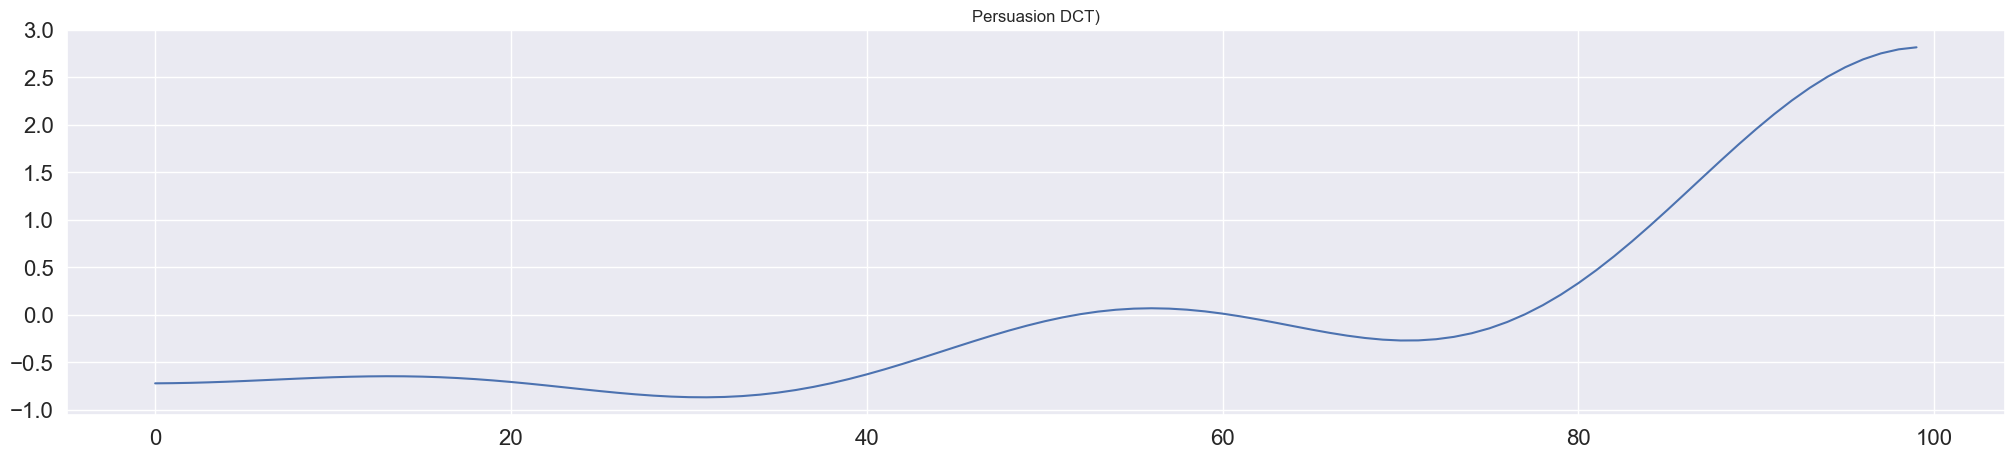

In [21]:
SyuzhetBook(DOC.polarity, 'Persuasion').plot_smooth(low_pass_size=6)